# imports

In [28]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import glob
import os
import pickle
import pandas as pd
import matplotlib
import random
import seaborn

from NDNT import NDN
import NDNT.utils as utils # some other utilities
import ColorDataUtils.mattprintlib as mprint
import ColorDataUtils.mattplotlib as mplt
from ColorDataUtils.multidata_utils import MultiExperiment

class Model:
    def __init__(self):
        pass
#from models import iter_core, cnn_core

device = torch.device("cuda:1")

datadir = '/Data/ColorV1/'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load data

In [14]:
expts = MultiExperiment(names=['J220715', 'J220722', 'J220707', 'J220801'],
                        datadir=datadir,
                        num_lags=16,
                        et_metric_thresh=0.8,
                        array_types=['UT', 'UT', 'UT', 'UT'],
                        luminance_only=True)
data, _, _ = expts.load(build_stim=True)

  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
598080 total time steps, 882 units
J220715 68.5% fixations remaining
J220722 64.8% fixations remaining
J220707 65.3% fixations remaining
J220801 66.8% fixations remaining
  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:10<00:00,  3.20it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 49
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 49
  Writing ETstim 0: overlap 11, 51
  Writing ETstim 1: overlap 11, 48
  Adding fixation point
  Shifting stim...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.00it/s]


  CROP: New stim size: 60 x 60
  Done: expt 1
  Stim expansion for shift: [905, 495, 1005, 595]
  Writing lam stim 0: overlap 60, 60
  Writing ETstim 0: overlap 41, 60
  Writing ETstim 1: overlap 60, 26
  Adding fixation point
  Shifting stim...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:09<00:00,  3.11it/s]


  CROP: New stim size: 60 x 60
  Done: expt 2
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 52
  Writing lam stim 1: overlap 60, 48
  Writing lam stim 2: overlap 30, 48
  Writing lam stim 3: overlap 30, 52
  Writing ETstim 0: overlap 9, 48
  Writing ETstim 1: overlap 9, 50
  Adding fixation point
  Shifting stim...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.20it/s]


  CROP: New stim size: 60 x 60
  Done: expt 3
Stimulus assembly complete


# load models

In [39]:
models = {
    'ind_expt': [],
    'ind_model': [],
    'ind_LLs': [],
    'ind_init': [],
    'cor_expt': [],
    'cor_model': [],
    'cor_LLs': [],
    'cor_init': []
}

expt_names = ['J220715', 'J220722', 'J220707', 'J220801']
for e, expt in enumerate(expt_names):
    for i in range(5):
        for j in range(5):
            path = '../models/ori_sfn/individual_models/'
            filename = path+'model_rotated_frozenb_'+expt+'_'+str(i)
            with open(filename+'.pkl', 'rb') as f:
                model = pickle.load(f)
            with open(filename+'.npy', 'rb') as f:
                LLs = np.load(f)
            models['ind_model'].append(model)
            models['ind_LLs'].append(np.mean(LLs))
            models['ind_expt'].append(expt)
            models['ind_init'].append(i)

            # load core model
            path = '../models/ori_sfn/core/'
            filename = path+'model_rotated_frozenb_'+str(j)
            with open(filename+'.pkl', 'rb') as f:
                model = pickle.load(f)
            with open(filename+'.npy', 'rb') as f:
                LLs = np.load(f)
            start,end = expts.experiment_boundaries[e]
            expt_LLs = np.mean(LLs[start:end])
            models['cor_model'].append(model)
            models['cor_LLs'].append(expt_LLs)
            models['cor_expt'].append(expt)
            models['cor_init'].append(j)

# convert models to a DataFrame
models = pd.DataFrame(models)

In [40]:
models

,ind_expt,ind_model,ind_LLs,ind_init,cor_expt,cor_model,cor_LLs,cor_init
0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031444,0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031242,0
1,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031444,0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029410,1
2,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031444,0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.029993,2
3,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031444,0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031141,3
4,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.031444,0,J220715,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.030541,4
...,...,...,...,...,...,...,...,...
95,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.044372,4,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.044655,0
96,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.044372,4,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.043865,1
97,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.044372,4,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.045454,2
98,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.044372,4,J220801,NDN(\n (loss_module): PoissonLoss_datafilter(...,0.045341,3


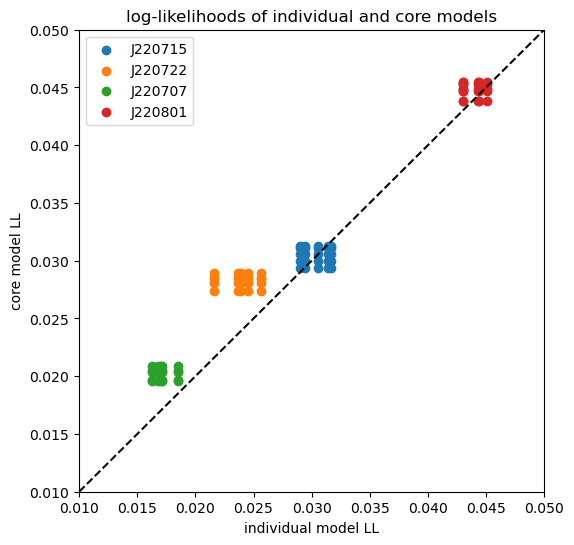

In [41]:
# make a scatterplot comparing the ind_LLs and the cor_LLs
# on each axis
# colored by the experiment
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
for expt in expt_names:
    expt_models = models[models['ind_expt']==expt]
    # scatter plot comparing the individual and core LLs
    # change the color per experiment
    # and marker per model
    ax.scatter(expt_models['ind_LLs'], expt_models['cor_LLs'], label=expt)
ax.set_xlabel('individual model LL')
ax.set_ylabel('core model LL')
ax.legend()
# set the axis limits to be the same (0.010 to 0.050)
ax.set_xlim([0.010, 0.050])
ax.set_ylim([0.010, 0.050])
# draw a diagonal line
ax.plot([0.010, 0.050], [0.010, 0.050], color='k', linestyle='--')
plt.title('log-likelihoods of individual and core models')
plt.show()

In [68]:
models[models['cor_init']==0]['cor_LLs']

0     0.031242
5     0.031242
10    0.031242
15    0.031242
20    0.031242
25    0.028055
30    0.028055
35    0.028055
40    0.028055
45    0.028055
50    0.020858
55    0.020858
60    0.020858
65    0.020858
70    0.020858
75    0.044655
80    0.044655
85    0.044655
90    0.044655
95    0.044655
Name: cor_LLs, dtype: float32

In [80]:
print(np.mean(models[models['ind_expt']=='J220801']['ind_LLs']))

cor_models = models[models['cor_init']==0]
cor_models['cor_expt']

0.04396543


0     J220715
5     J220715
10    J220715
15    J220715
20    J220715
25    J220722
30    J220722
35    J220722
40    J220722
45    J220722
50    J220707
55    J220707
60    J220707
65    J220707
70    J220707
75    J220801
80    J220801
85    J220801
90    J220801
95    J220801
Name: cor_expt, dtype: object

(5, 4)


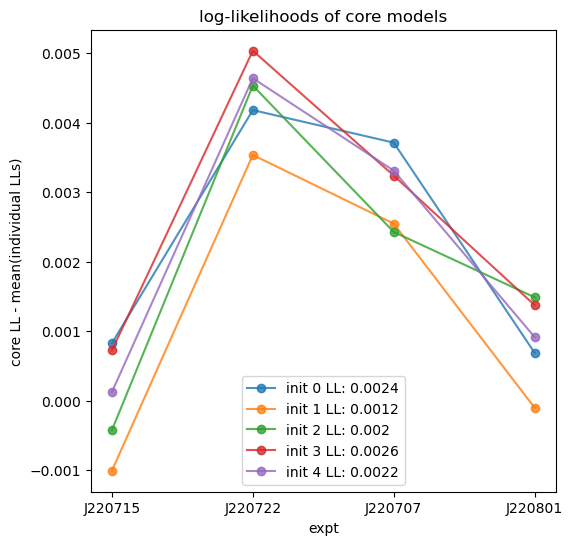

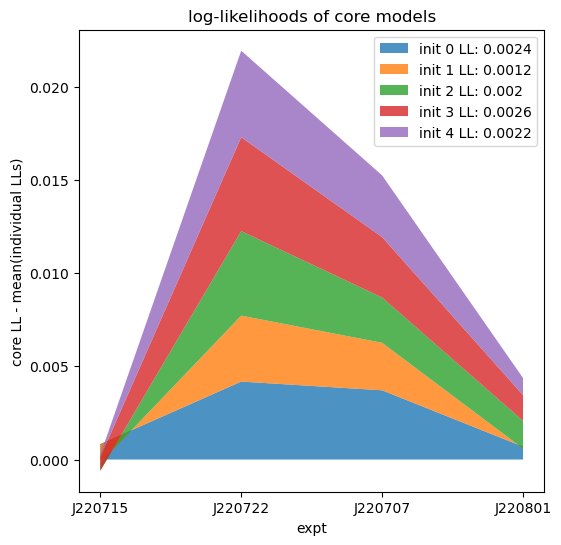

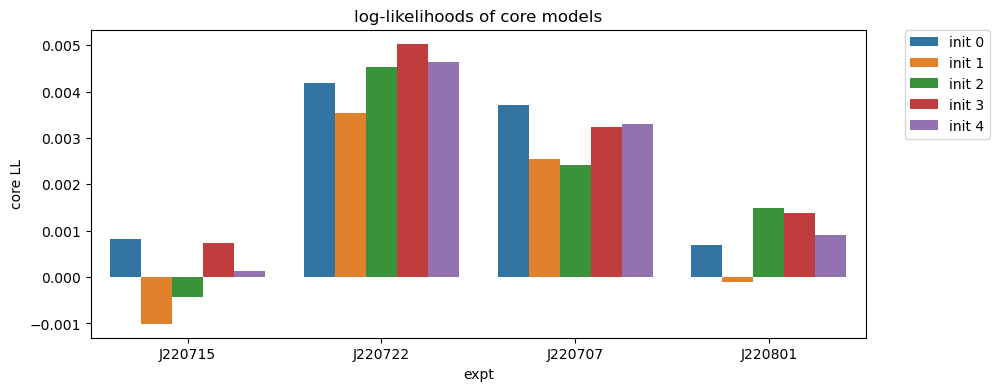

In [121]:
# make a scatter plot comparing the core_init to the core_LLs
# on each axis
# colored by the experiment
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

diff_LLses = []
for init in range(5):
    cor_models = models[models['cor_init']==init]
    ind_models = models[models['ind_init']==init]

    # scatter plot comparing the individual and core LLs
    # change the color per experiment
    # and marker per model
    diff_LLs = []
    for expt in expt_names:
        ind_mean_LL = np.mean(models[models['ind_expt']==expt]['ind_LLs'])
        cor_LL = cor_models[cor_models['cor_expt']==expt]['cor_LLs'].iloc[0]
        diff_LL = cor_LL - ind_mean_LL
        diff_LLs.append(diff_LL)
    diff_LLses.append(diff_LLs)
    ax.plot(expt_names, diff_LLs, alpha=0.8, marker='o')
    ax.set_xlabel('expt')
    ax.set_ylabel('core LL - mean(individual LLs)')
    # set the ticks of the x-axis to be integers
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
diff_LLses = np.array(diff_LLses)
print(diff_LLses.shape)
ax.legend(['init '+str(i) + ' LL: '+str(np.round(np.mean(diff_LLses[i,:]), 4)) for i in range(5)])
plt.title('log-likelihoods of core models')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.stackplot(expt_names, diff_LLses, alpha=0.8)
ax.set_xlabel('expt')
ax.set_ylabel('core LL - mean(individual LLs)')
# set the ticks of the x-axis to be integers
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax.legend(['init '+str(i) + ' LL: '+str(np.round(np.mean(diff_LLses[i,:]), 4)) for i in range(5)])
plt.title('log-likelihoods of core models')
plt.show()

diff_pd = pd.DataFrame(diff_LLses.T, columns=['init '+str(i) for i in range(5)])
diff_pd['expt'] = expt_names
diff_pd = pd.melt(diff_pd, id_vars=['expt'], var_name='init', value_name='cor_LLs')

# plot side by side bar chart for each expt using seaborn
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax = seaborn.barplot(x='expt', y='cor_LLs', hue='init', data=diff_pd)
# plot the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('expt')
ax.set_ylabel('core LL')
plt.title('log-likelihoods of core models')
plt.show()